In [1]:
import time, random, os
from CosyMatrix import CosyMatrix
from CosyMagnet import CosyMagnet
from Emulator import Emulator
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import CubicSpline
from CosyIO import CosyIO

In [2]:
# Get the list of all files and directories
path = "C:/Users/dioge/Code/GitHub/2023-FRIB-TA-Summer-School/model-mixing/RBMSecar/Emulator/MagnetData/Magnet_1_v2"
dir_list = os.listdir(path)
scales = [ float(name) for name in dir_list ]

In [3]:
''' Load all the files in the directory '''

big_matrix = []
cosyIO = CosyIO()
for i in range(len(dir_list)):
    cosyIO.read(os.path.join(path,dir_list[i]))
    big_row = []
    for mat in cosyIO.matrices:
        for row in mat:
            big_row.append(row)
    big_matrix.append(big_row)
big_matrix = np.array(big_matrix)

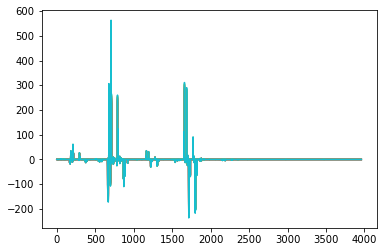

In [4]:
for i in range(10):
    plt.plot(big_matrix[i])
plt.show()

In [5]:
class Emulator2:
    def __init__(self,axis,matrix,cutoff):
        self.axis   = axis
        self.matrix = matrix
        self.cutoff = cutoff
        self.height,self.width = self.matrix.shape
        self.build()
    
    def normalize(self):
        ''' Compute normalizations of the data '''
        self.means = [ np.average(self.matrix[:,i]) for i in range(self.width) ]
        self.sdevs = [ np.std(self.matrix[:,i])     for i in range(self.width) ]
        
        ''' Only add to renormalized data the non-constant channels '''
        self.renor = []
        
        ''' Mapping between emulated and total channels '''
        self.map = {}
        emulated = 0
        for i in range(self.height):
            row = []
            for j in range(self.width):
                row = []
                if self.sdevs[j] != 0:
                    row.append( (self.matrix[i][j]-self.means[j]) / self.sdevs[j] )
            self.map[emulated] = i
            emulated += 1
        
        #self.renor = [ [
        #                        ( self.matrix[i][j]-self.means[j] )/self.sdevs[j] 
        #                    if self.sdevs[j] != 0 else 0 
        #                for j in range(self.width) ] 
        #              for i in range(self.height) ]
        self.renor  = np.array(self.renor)
        self.ewidth = len(self.renor)
    
    def build(self):
        self.normalize()
        self.u,self.s,self.v = np.linalg.svd(self.renor)
        self.splines = [ sp.interpolate.CubicSpline(self.axis,self.u[:,i]) for i in range(self.cutoff) ]
    
    def __call__(self,value):
        ''' Actual Magnet representation '''
        rval = np.zeros(self.width)
        
        ''' Loop over proncipal components '''
        emul = np.zeros(self.ewidth)
        for i in range(self.cutoff):
            emul += self.splines[i](value)*self.s[i]*self.v[i]
        
        ''' Convert back to possibly constant channels '''
        for key in self.map:
            rval[self.map[key]] = emul[key]
        
        ''' Rescale back data '''
        rval = np.multiply(rval,self.sdevs) + self.means
        return rval

def error(emulated,real):
    return np.sqrt(np.sum(np.square(emulated - real))/np.sum(np.square(real)))

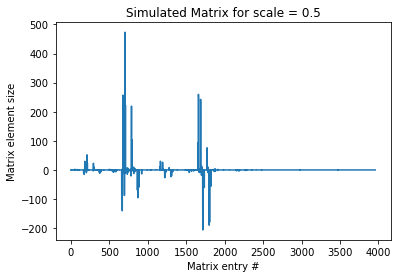

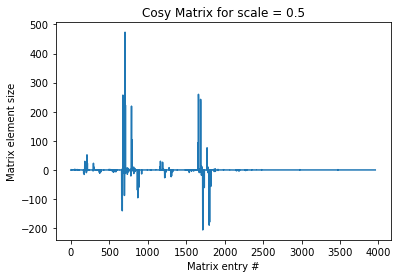

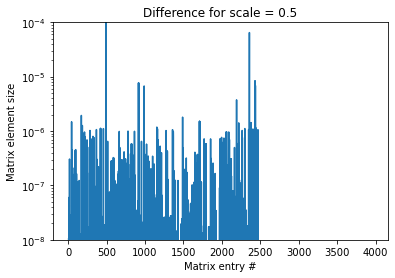

In [6]:
''' Test one emulator instance '''
from math import *

MagnetEmulator = Emulator(scales,big_matrix,15)

plt.plot(MagnetEmulator(0.5))
plt.title("Simulated Matrix for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()
plt.plot(big_matrix[0])
plt.title("Cosy Matrix for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()

emulated = MagnetEmulator(0.5)
real     = big_matrix[0]
relative = [ abs(real[i]-emulated[i]) / ( real[i] if real[i]!=0 else (emulated[i] if emulated[i]!=0 else 1) ) for i in range(len(real)) ]

plt.semilogy(relative)
plt.ylim(1E-8,1E-4)
plt.title("Difference for scale = 0.5")
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.show()

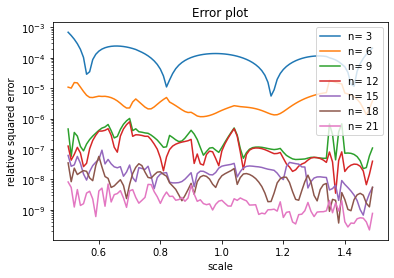

In [7]:
''' Tests several instances '''
nEmulators = 7
Emulators  = [ Emulator(scales,big_matrix,3*i+3) for i in range(nEmulators) ]
error_matrix = [ [ error(Emulators[i](scales[j]),big_matrix[j]) for j in range(len(scales)) ] for i in range(nEmulators) ]
for i in range(nEmulators):
    plt.semilogy(scales,error_matrix[i],label="n= "+str(3*i+3))
plt.xlabel("scale")
plt.ylabel("relative squared error")
plt.title("Error plot")
plt.legend()
plt.show()

In [8]:
''' Timing checkup '''

path_magnet1 = "C:/Users/dioge/Code/GitHub/2023-FRIB-TA-Summer-School/model-mixing/RBMSecar/Emulator/MagnetData/Magnet_1_v2"
magnet1 = CosyMagnet(path=path_magnet1,cutoff=21)

minimum = min(magnet1.axis)
maximum = max(magnet1.axis)

nevals = 10000

start = time.time()
for i in range(nevals):
    scale = minimum + random.random()*(maximum-minimum)
    magnet1(scale)
print(str(nevals),"evaluations took",time.time()-start,"seconds")

10000 evaluations took 9.117043018341064 seconds


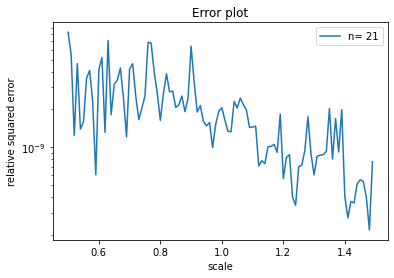

In [9]:
''' Accuarcy checkup '''
error_matrix = [ error(magnet1(magnet1.axis[i]),magnet1.matrix[i]) for i in range(len(magnet1.axis)) ] 
plt.semilogy(magnet1.axis,error_matrix,label="n= "+str(magnet1.cutoff))
plt.xlabel("scale")
plt.ylabel("relative squared error")
plt.title("Error plot")
plt.legend()
plt.show()

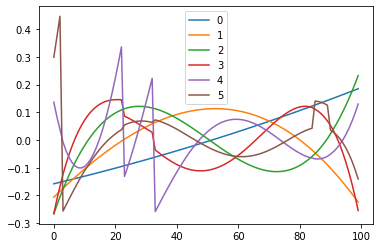

In [10]:
for i in range(6):
    plt.plot(magnet1.u[:,i],label=str(i))
plt.legend()
plt.show()

In [11]:
''' Sample use of the parser '''
scale = 0.35626215
magnet1.write(scale,str(scale))